# 파이토치를 활요한 MNIST 손글씨 데이터 분류

In [80]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)

### 1. 데이터 전처리

Label is 5


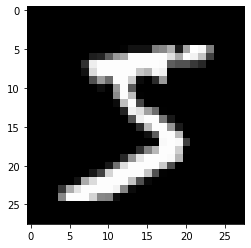

In [81]:
X = mnist.data / 255 # [0, 1] 구간으로 정규화
Y = mnist.target.astype(np.int8)

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[0].reshape(28, 28), cmap = 'gray')
print(f"Label is {Y[0]}")

### 2. DataLoader 생성
- 정규화를 마친 MNIST데이터를 파이토치 신경망에서 다룰 수 있게 DataLoader 객체로 변환한다.
- step
    - 훈련 데이터와 테스트 데이터로 분할
    - Numpy 배열을 Tensor 객체로 변환
    - DataSet 객체 생성
    - DataSet 객체를 DataLoader 객체로 변환

In [82]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [83]:
# 2.1 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/7, random_state=0) # 6 : 1비율로 데이터 분할

In [84]:
# 2.2 데이터를 파이토치 텐서로 변환
# torch.tensor의 경우 데이터를 항상 복사를 하지만 torch.Tensor의 경우 파이토치 텐서로 변환을 한다.
# CPU에서 실행할 때는 .cuda()를 없애고 실행한다.
X_train = torch.Tensor(X_train).cuda()
X_test = torch.Tensor(X_test).cuda()
Y_train = torch.LongTensor(Y_train).cuda()
Y_test = torch.LongTensor(Y_test).cuda()

In [85]:
# 2.3 데이터와 정답 레이블을 하나로 묶어 DataSet으로 만듬
ds_train = TensorDataset(X_train, Y_train) # TensorDataset함수는 첫번째 차원의 dimension이 같을 때 하나의 데이터셋으로 만들어줌
ds_test = TensorDataset(X_test, Y_test)

In [86]:
# 2.4 미니 배치 크기를 지정해 DataLoader객체로 변환
# Chainer의 iterators.SerialIterator와 비슷함
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

### 3. 신경망 구성

In [87]:
from torch import nn

# 2개의 hidden layer를 이용해 구성
model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))
model.cuda() # GPU로 실행, CPU로 실행할 때는 이 줄을 주석 처리한다.
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


### 4. 오차함수 및 최적화 기법 설정

In [88]:
from torch import optim

# 오차 함수 선택
loss_fn = nn.CrossEntropyLoss() # criterion(표준)을 변수명으로 사용하는 경우가 많다

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

### 5. 학습 및 추론 설정

In [89]:
# 학습 중 1 에포크에서 수행할 일을 함수로 정의
# 파이토치에는 Chainer의 training.Trainer()에 해당하는 것이 없음
def train(epoch):
    model.train() # 신경망을 학습 모드로 전환
    for data, targets in loader_train: # 미니 배치를 하나씩 꺼내 학습을 진행
        optimizer.zero_grad() # 경사를 0으로 초기화함
        outputs = model(data) # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets) # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward() # 오차를 역전파 계산
        optimizer.step() # 역전파 계산한 값으로 가중치를 수정
    print(f"Epoch : {epoch:5d} 완료")

In [90]:
# 추론 1 에포크에서 할 일을 함수로 정의
# 파이토치에는 Chainer의 trainer.extend(extensions.Evaluator())에 해당하는 것이 없음
def test():
    model.eval() # 신경망을 추론 모드로 전환
    correct = 0
    
    # 데이터 로데에서 미니 배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():
        for data, targets in loader_test:
            outputs = model(data) # 데이터를 입력하고 출력을 계산
            # 추론 계산
            _, predicted = torch.max(outputs.data, 1) # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum() # 정답과 일치한 경우 정답 카운드를 증가
    data_num = len(loader_test.dataset) # 데이터의 총 건수
    print(f"Accuracy : {correct}/{data_num} ({(100. * correct / data_num):.9f}%)")

### 6. 학습 및 추론 수행

In [91]:
test()

Accuracy : 1005/10000 (10.050000191%)


In [92]:
for epoch in range(30):
    train(epoch)
test()

# GPU로 실행했을 때
# CPU times: user 56.3 s, sys: 579 ms, total: 56.9 s
# Wall time: 1min 4s

# CPU로 실행했을 때
# CPU times: user 4min 54s, sys: 229 ms, total: 4min 55s
# Wall time: 1min 14s

Epoch :     0 완료
Epoch :     1 완료
Epoch :     2 완료
Epoch :     3 완료
Epoch :     4 완료
Epoch :     5 완료
Epoch :     6 완료
Epoch :     7 완료
Epoch :     8 완료
Epoch :     9 완료
Epoch :    10 완료
Epoch :    11 완료
Epoch :    12 완료
Epoch :    13 완료
Epoch :    14 완료
Epoch :    15 완료
Epoch :    16 완료
Epoch :    17 완료
Epoch :    18 완료
Epoch :    19 완료
Epoch :    20 완료
Epoch :    21 완료
Epoch :    22 완료
Epoch :    23 완료
Epoch :    24 완료
Epoch :    25 완료
Epoch :    26 완료
Epoch :    27 완료
Epoch :    28 완료
Epoch :    29 완료
Accuracy : 9660/10000 (96.599998474%)


예측 결과 : 4
이 이미지 데이터의 정답 레이블은 4


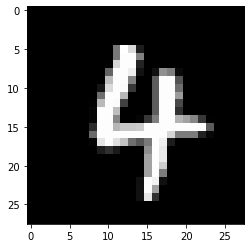

In [94]:
# 특정 이미지를 대상으로 추론 계산
index = 4000

model.eval() # 신경망을 추론 모드로 변경
data = X_test[index]
outputs = model(data)
_, predicted = torch.max(outputs.data, 0) # 여기서 0인 이유는 한장이기 때문 여러 장의 되면 2차원이 되므로 가장 마지막 차원에 대한 최댓값을 구해야 하기 떄문에 1이 된다.

print(f"예측 결과 : {predicted}")

X_test_show = (X_test[index]).to("cpu").numpy()
plt.imshow(X_test_show.reshape(28,28), cmap = "gray")
print(f"이 이미지 데이터의 정답 레이블은 {Y_test[index]}")

# 파이토치 사용법에 대한 보충 설명
- 체이너처럼 입력 데이터에 따라 유연하게 바뀌는 신경망을 구성하기 위해서는 다음과 같이 코딩한다.
- 입력 데이터 x에 따라 순전파 계산식이 바뀌는 것이 Define by run 설계 사상의 특징이다.

In [95]:
# 신경망 구성(체이너 스타일)
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__() # 이는 nn.Module.__init__()를 실행하기 위한 코드로 상속 받은 경우 반드시 써야 한다.
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        
        return output

In [96]:
model = Net(n_in=28*28*1, n_mid=100, n_out=10)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
